In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from matplotlib import pyplot
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [29]:
IMG_H = 64
IMG_W = 64
IMG_C = 3

In [30]:
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [33]:
def load_image(image_path, img_h=64, img_w=64):
    # Read the image file
    img = tf.io.read_file(image_path)

    # Decode the image as JPEG
    img = tf.io.decode_jpeg(img, channels=3)  # Ensures 3 channels for RGB

    # Resize the image with padding or cropping if necessary
    img = tf.image.resize_with_crop_or_pad(img, img_h, img_w)  # Resize to the target height and width

    # Cast the image to float32
    img = tf.cast(img, tf.float32)

    # Normalize the image to [-1, 1] range
    img = (img - 127.5) / 127.5

    return img


In [ ]:
def tf_dataset(images_path, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(images_path)
    dataset = dataset.shuffle(buffer_size=10240)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
def deconv_block(inputs, num_filters, kernel_size, strides, bn=True):
    x = Conv2DTranspose(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding="same",
        strides=strides,
        use_bias=False
        )(inputs)

    if bn:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
    return x

In [ ]:
def conv_block(inputs, num_filters, kernel_size, padding="same", strides=2, activation=True):
    x = Conv2D(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding=padding,
        strides=strides,
    )(inputs)

    if activation:
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.3)(x)
    return x

In [ ]:
def build_generator(latent_dim):
    f = [2**i for i in range(5)][::-1]
    filters = 32
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides

    noise = Input(shape=(latent_dim,), name="generator_noise_input")

    x = Dense(f[0] * filters * h_output * w_output, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((h_output, w_output, 16 * filters))(x)

    for i in range(1, 5):
        x = deconv_block(x,
            num_filters=f[i] * filters,
            kernel_size=5,
            strides=2,
            bn=True
        )

    x = conv_block(x,
        num_filters=3,
        kernel_size=5,
        strides=1,
        activation=False
    )
    fake_output = Activation("tanh")(x)

    return Model(noise, fake_output, name="generator")

In [ ]:
def build_discriminator():
    f = [2**i for i in range(4)]
    image_input = Input(shape=(IMG_H, IMG_W, IMG_C))
    x = image_input
    filters = 64
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides

    for i in range(0, 4):
        x = conv_block(x, num_filters=f[i] * filters, kernel_size=5, strides=2)

    x = Flatten()(x)
    x = Dense(1)(x)

    return Model(image_input, x, name="discriminator")

In [ ]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for _ in range(2):
            ## Train the discriminator
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            generated_images = self.generator(random_latent_vectors)
            generated_labels = tf.zeros((batch_size, 1))

            with tf.GradientTape() as ftape:
                predictions = self.discriminator(generated_images)
                d1_loss = self.loss_fn(generated_labels, predictions)
            grads = ftape.gradient(d1_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

            ## Train the discriminator
            labels = tf.ones((batch_size, 1))

            with tf.GradientTape() as rtape:
               predictions = self.discriminator(real_images)
               d2_loss = self.loss_fn(labels, predictions)
            grads = rtape.gradient(d2_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        ## Train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as gtape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = gtape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d1_loss": d1_loss, "d2_loss": d2_loss, "g_loss": g_loss}



In [37]:
import os
import matplotlib.pyplot as plt

def save_plot(examples, epoch, n):
    # Rescale images from [-1, 1] to [0, 1]
    examples = (examples + 1) / 2.0

    # Ensure the 'samples' directory exists
    if not os.path.exists('samples'):
        os.makedirs('samples')

    plt.figure(figsize=(n, n))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.axis("off")
        plt.imshow(examples[i])

    # Save the plot
    filename = f"samples/generated_plot_epoch-{epoch + 1}.png"
    plt.savefig(filename)
    plt.close()


In [23]:
if __name__ == "__main__":
    ## Hyperparameters
    batch_size = 128
    latent_dim = 128
    num_epochs = 60
    images_path = glob("data/*")

    d_model = build_discriminator()
    g_model = build_generator(latent_dim)

    # d_model.load_weights("saved_model/d_model.h5")
    # g_model.load_weights("saved_model/g_model.h5")

    d_model.summary()
    g_model.summary()

    gan = GAN(d_model, g_model, latent_dim)

    bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    gan.compile(d_optimizer, g_optimizer, bce_loss_fn)

    images_dataset = tf_dataset('/content/archive.zip', 128)

    for epoch in range(num_epochs):
        gan.fit(images_dataset, epochs=1)
        g_model.save("saved_model/g_model.h5")
        d_model.save("saved_model/d_model.h5")

        n_samples = 25
        noise = np.random.normal(size=(n_samples, latent_dim))
        examples = g_model.predict(noise)
        save_plot(examples, epoch, int(np.sqrt(n_samples)))


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 32, 32, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_36 (LeakyReLU)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_37 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 8, 8, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_38 (LeakyReLU)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 4, 4, 512)           │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_39 (LeakyReLU)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,314,753 (16.46 MB)

 Trainable params: 4,314,753 (16.46 MB)

 Non-trainable params: 0 (0.00 B)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ generator_noise_input (InputLayer)   │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 8192)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 8192)                │          32,768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_40 (LeakyReLU)           │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_16                  │ (None, 8, 8, 256)           │       3,276,800 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_41 (LeakyReLU)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_17                  │ (None, 16, 16, 128)         │         819,200 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_42 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_18                  │ (None, 32, 32, 64)          │         204,800 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_43 (LeakyReLU)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_19                  │ (None, 64, 64, 32)          │          51,200 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_44 (LeakyReLU)           │ (None, 64, 64, 32)          │              

 Total params: 5,437,667 (20.74 MB)

 Trainable params: 5,420,323 (20.68 MB)

 Non-trainable params: 17,344 (67.75 KB)

NotADirectoryError: [Errno 20] Not a directory: '/content/archive.zip'

In [22]:
import zipfile
import os

def extract_zip(zip_path, extract_to):
    # Extract the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def tf_dataset(images_dir, batch_size):
    # Get the list of image paths after extraction
    images_path = [os.path.join(images_dir, filename) for filename in os.listdir(images_dir)]

    # Ensure images_path is a list of strings (file paths)
    images_path = [str(path) for path in images_path if path.endswith('.jpg') or path.endswith('.png')]  # Modify extensions based on your image type

    # Create a TensorFlow dataset from image paths
    dataset = tf.data.Dataset.from_tensor_slices(images_path)

    def load_image(image_path):
        img = tf.io.read_file(image_path)  # This line expects 'image_path' to be a string
        img = tf.image.decode_jpeg(img, channels=3)  # Modify according to your image type
        img = tf.image.resize(img, [256, 256])  # Resize or process the image as needed
        img = img / 255.0  # Normalize the image
        return img

    dataset = dataset.map(load_image)  # Apply the load_image function to each image path
    dataset = dataset.batch(batch_size)

    return dataset

# Extract the ZIP file
zip_path = '/content/Humans.zip'
extracted_dir = '/content/Humans/'
extract_zip(zip_path, extracted_dir)

# Pass the extracted image directory to the tf_dataset function
images_dataset = tf_dataset(extracted_dir, 128)

# Now you can use images_dataset in your training loop


BadZipFile: File is not a zip file

In [24]:
import zipfile
import os

def extract_zip(zip_path, extract_to):
    # Extract the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted ZIP file to {extract_to}")

def tf_dataset(images_dir, batch_size):
    # Get the list of image paths after extraction
    images_path = [os.path.join(images_dir, filename) for filename in os.listdir(images_dir) if filename.endswith('.jpg') or filename.endswith('.png')]

    # Create a TensorFlow dataset from image paths
    dataset = tf.data.Dataset.from_tensor_slices(images_path)

    def load_image(image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)  # Modify according to your image type
        img = tf.image.resize(img, [256, 256])  # Resize or process the image as needed
        img = img / 255.0  # Normalize the image
        return img

    dataset = dataset.map(load_image)  # Apply the load_image function to each image path
    dataset = dataset.batch(batch_size)

    return dataset

# Extract the ZIP file
zip_path = '/content/archive.zip'
extracted_dir = '/content/extracted_images/'
extract_zip(zip_path, extracted_dir)

# Pass the extracted image directory to the tf_dataset function
images_dataset = tf_dataset(extracted_dir, 128)

# Now you can use images_dataset in your training loop


Extracted ZIP file to /content/extracted_images/


TypeError: in user code:

    File "<ipython-input-24-3f1b5d3f6b7c>", line 18, in load_image  *
        img = tf.io.read_file(image_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [26]:
import shutil
import os
import tensorflow as tf

# Function to extract the ZIP file
def extract_zip(zip_path, extract_to):
    try:
        shutil.unpack_archive(zip_path, extract_to)
        print("ZIP file extracted successfully.")
    except shutil.ReadError:
        print(f"Error: '{zip_path}' is not a valid archive.")

# Function to create a TensorFlow dataset from the extracted images
def tf_dataset(images_dir, batch_size):
    # Get the list of image paths after extraction
    images_path = [os.path.join(images_dir, filename) for filename in os.listdir(images_dir) if filename.endswith('.jpg') or filename.endswith('.png')]

    # Convert paths to strings explicitly (though they should already be strings)
    images_path = [str(path) for path in images_path]

    dataset = tf.data.Dataset.from_tensor_slices(images_path)

    def load_image(image_path):
        # Ensure that image_path is passed correctly as a string
        img = tf.io.read_file(image_path)  # 'image_path' should be a string
        img = tf.image.decode_jpeg(img, channels=3)  # Modify this based on image format
        img = tf.image.resize(img, [256, 256])
        img = img / 255.0  # Normalize the image
        return img

    dataset = dataset.map(load_image)
    dataset = dataset.batch(batch_size)

    return dataset

# Extract the ZIP file
zip_path = '/content/archive.zip'
extracted_dir = '/content/extracted_images/'
extract_zip(zip_path, extracted_dir)

# Pass the extracted image directory to the tf_dataset function
images_dataset = tf_dataset(extracted_dir, 128)

# Now you can use the images_dataset in your training loop


ZIP file extracted successfully.


TypeError: in user code:

    File "<ipython-input-26-5fed49cdefa5>", line 25, in load_image  *
        img = tf.io.read_file(image_path)  # 'image_path' should be a string

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [35]:
import shutil
import os
import tensorflow as tf

# Function to extract the ZIP file
def extract_zip(zip_path, extract_to):
    try:
        shutil.unpack_archive(zip_path, extract_to)
        print("ZIP file extracted successfully.")
    except shutil.ReadError:
        print(f"Error: '{zip_path}' is not a valid archive.")

# Generator function to yield image paths as strings
def image_path_generator(images_dir):
    for filename in os.listdir(images_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            yield os.path.join(images_dir, filename)

# Function to create a TensorFlow dataset from the extracted images
def tf_dataset(images_dir, batch_size):
    # Create a generator dataset from image paths
    dataset = tf.data.Dataset.from_generator(
        lambda: image_path_generator(images_dir),
        output_signature=tf.TensorSpec(shape=(), dtype=tf.string)
    )

    def load_image(image_path):
        img = tf.io.read_file(image_path)  # 'image_path' is guaranteed to be a string now
        img = tf.image.decode_jpeg(img, channels=3)  # Modify this based on image format
        img = tf.image.resize(img, [64, 64])
        img = img / 255.0  # Normalize the image
        return img

    dataset = dataset.map(load_image)
    dataset = dataset.batch(batch_size)

    return dataset

# Extract the ZIP file
zip_path = '/content/archive.zip'
extracted_dir = '/content/extracted_images/'
extract_zip(zip_path, extracted_dir)

# Pass the extracted image directory to the tf_dataset function
images_dataset = tf_dataset(extracted_dir, 128)

# Now you can use the images_dataset in your training loop


ZIP file extracted successfully.


In [38]:
if __name__ == "__main__":
    ## Hyperparameters
    batch_size = 128
    latent_dim = 128
    num_epochs = 60
    images_path = glob("data/*")

    d_model = build_discriminator()
    g_model = build_generator(latent_dim)

    # d_model.load_weights("saved_model/d_model.h5")
    # g_model.load_weights("saved_model/g_model.h5")

    d_model.summary()
    g_model.summary()

    gan = GAN(d_model, g_model, latent_dim)

    bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    gan.compile(d_optimizer, g_optimizer, bce_loss_fn)

    images_dataset = tf_dataset('/content/extracted_images/data/data', 128)

    for epoch in range(num_epochs):
        gan.fit(images_dataset, epochs=1)
        g_model.save("saved_model/g_model.h5")
        d_model.save("saved_model/d_model.h5")

        n_samples = 25
        noise = np.random.normal(size=(n_samples, latent_dim))
        examples = g_model.predict(noise)
        save_plot(examples, epoch, int(np.sqrt(n_samples)))


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 32, 32, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_81 (LeakyReLU)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_82 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 8, 8, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_83 (LeakyReLU)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 4, 4, 512)           │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_84 (LeakyReLU)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,314,753 (16.46 MB)

 Trainable params: 4,314,753 (16.46 MB)

 Non-trainable params: 0 (0.00 B)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ generator_noise_input (InputLayer)   │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 8192)                │       1,048,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 8192)                │          32,768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_85 (LeakyReLU)           │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_9 (Reshape)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_36                  │ (None, 8, 8, 256)           │       3,276,800 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_86 (LeakyReLU)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_37                  │ (None, 16, 16, 128)         │         819,200 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_87 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_38                  │ (None, 32, 32, 64)          │         204,800 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_88 (LeakyReLU)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_39                  │ (None, 64, 64, 32)          │          51,200 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_89 (LeakyReLU)           │ (None, 64, 64, 32)          │              

 Total params: 5,437,667 (20.74 MB)

 Trainable params: 5,420,323 (20.68 MB)

 Non-trainable params: 17,344 (67.75 KB)

169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 395ms/step - d1_loss: 0.3479 - d2_loss: 0.2931 - g_loss: 1.9387


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 375ms/step - d1_loss: 0.2103 - d2_loss: 0.2690 - g_loss: 2.6795


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 376ms/step - d1_loss: 0.2121 - d2_loss: 0.2515 - g_loss: 2.8164


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 376ms/step - d1_loss: 0.2129 - d2_loss: 0.2454 - g_loss: 2.8674


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 377ms/step - d1_loss: 0.2141 - d2_loss: 0.2428 - g_loss: 2.9441


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 377ms/step - d1_loss: 0.2154 - d2_loss: 0.2465 - g_loss: 2.9299


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 373ms/step - d1_loss: 0.2166 - d2_loss: 0.2369 - g_loss: 2.9839


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 374ms/step - d1_loss: 0.2222 - d2_loss: 0.2394 - g_loss: 2.9947


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 62s 363ms/step - d1_loss: 0.2165 - d2_loss: 0.2340 - g_loss: 2.9374


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 361ms/step - d1_loss: 0.2202 - d2_loss: 0.2327 - g_loss: 2.9376


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 62s 366ms/step - d1_loss: 0.2234 - d2_loss: 0.2353 - g_loss: 2.9536


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 375ms/step - d1_loss: 0.2215 - d2_loss: 0.2308 - g_loss: 2.9018


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 377ms/step - d1_loss: 0.2276 - d2_loss: 0.2329 - g_loss: 2.9639


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 374ms/step - d1_loss: 0.2277 - d2_loss: 0.2316 - g_loss: 2.9461


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 377ms/step - d1_loss: 0.2264 - d2_loss: 0.2303 - g_loss: 2.9662


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 377ms/step - d1_loss: 0.2319 - d2_loss: 0.2278 - g_loss: 2.9991


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 373ms/step - d1_loss: 0.2316 - d2_loss: 0.2264 - g_loss: 3.0960


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 377ms/step - d1_loss: 0.2336 - d2_loss: 0.2247 - g_loss: 3.1487


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 373ms/step - d1_loss: 0.2366 - d2_loss: 0.2258 - g_loss: 3.1510


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 377ms/step - d1_loss: 0.7726 - d2_loss: 0.3551 - g_loss: 2.7108


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 374ms/step - d1_loss: 0.2462 - d2_loss: 0.2320 - g_loss: 2.7402


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 378ms/step - d1_loss: 0.2554 - d2_loss: 0.2280 - g_loss: 2.8883


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 374ms/step - d1_loss: 0.2575 - d2_loss: 0.2258 - g_loss: 3.0183


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 374ms/step - d1_loss: 0.2570 - d2_loss: 0.2249 - g_loss: 3.1056


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 62s 367ms/step - d1_loss: 0.2592 - d2_loss: 0.2236 - g_loss: 3.1794


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 361ms/step - d1_loss: 0.2643 - d2_loss: 0.2238 - g_loss: 3.2952


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 358ms/step - d1_loss: 0.4929 - d2_loss: 0.3994 - g_loss: 2.6292


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 362ms/step - d1_loss: 0.2714 - d2_loss: 0.2304 - g_loss: 2.8054


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 364ms/step - d1_loss: 0.2751 - d2_loss: 0.2239 - g_loss: 3.0044


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 359ms/step - d1_loss: 0.2784 - d2_loss: 0.2230 - g_loss: 3.1703


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 363ms/step - d1_loss: 0.2747 - d2_loss: 0.2226 - g_loss: 3.2364


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 374ms/step - d1_loss: 0.2720 - d2_loss: 0.2226 - g_loss: 3.3030


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 372ms/step - d1_loss: 0.3145 - d2_loss: 0.2812 - g_loss: 3.0247


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 377ms/step - d1_loss: 0.2730 - d2_loss: 0.2186 - g_loss: 3.2905


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 374ms/step - d1_loss: 0.2769 - d2_loss: 0.2200 - g_loss: 3.4321


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 62s 368ms/step - d1_loss: 0.2736 - d2_loss: 0.2226 - g_loss: 3.3035


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 377ms/step - d1_loss: 0.2672 - d2_loss: 0.2171 - g_loss: 3.4574


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 374ms/step - d1_loss: 0.4162 - d2_loss: 0.3100 - g_loss: 2.8034


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 376ms/step - d1_loss: 0.2668 - d2_loss: 0.2173 - g_loss: 3.0862


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 374ms/step - d1_loss: 0.2729 - d2_loss: 0.2175 - g_loss: 3.2777


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 373ms/step - d1_loss: 0.2687 - d2_loss: 0.2186 - g_loss: 3.3828


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 377ms/step - d1_loss: 0.2777 - d2_loss: 0.2204 - g_loss: 3.5094


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 378ms/step - d1_loss: 0.2888 - d2_loss: 0.2778 - g_loss: 3.0027


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 374ms/step - d1_loss: 0.2637 - d2_loss: 0.2153 - g_loss: 3.3524


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 374ms/step - d1_loss: 0.2740 - d2_loss: 0.2217 - g_loss: 3.4232


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 374ms/step - d1_loss: 0.2629 - d2_loss: 0.2185 - g_loss: 3.3074


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 378ms/step - d1_loss: 0.2646 - d2_loss: 0.2185 - g_loss: 3.4201


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 377ms/step - d1_loss: 0.2761 - d2_loss: 0.2225 - g_loss: 3.5547


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 373ms/step - d1_loss: 0.2754 - d2_loss: 0.2256 - g_loss: 3.3189


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 374ms/step - d1_loss: 0.2437 - d2_loss: 0.2139 - g_loss: 3.2563


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 374ms/step - d1_loss: 0.2501 - d2_loss: 0.2181 - g_loss: 3.4024


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 375ms/step - d1_loss: 0.4848 - d2_loss: 0.3099 - g_loss: 2.7788


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 374ms/step - d1_loss: 0.2527 - d2_loss: 0.2120 - g_loss: 3.1532


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 374ms/step - d1_loss: 0.2538 - d2_loss: 0.2129 - g_loss: 3.3378


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 374ms/step - d1_loss: 0.2559 - d2_loss: 0.2159 - g_loss: 3.4367


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 377ms/step - d1_loss: 0.3290 - d2_loss: 0.4228 - g_loss: 3.0780


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 376ms/step - d1_loss: 0.2531 - d2_loss: 0.2126 - g_loss: 3.0277


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 377ms/step - d1_loss: 0.2627 - d2_loss: 0.2123 - g_loss: 3.3312


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 377ms/step - d1_loss: 0.2561 - d2_loss: 0.2142 - g_loss: 3.4151


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 376ms/step - d1_loss: 0.3876 - d2_loss: 0.2996 - g_loss: 3.0960


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


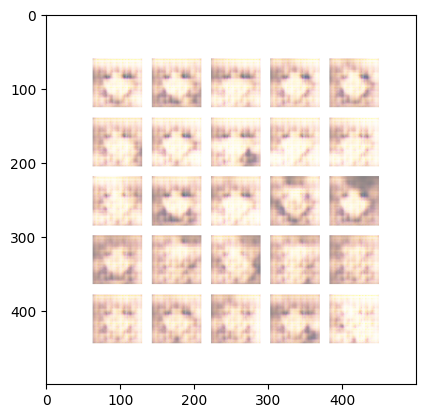

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('samples/generated_plot_epoch-1.png')
imgplot = plt.imshow(img)
plt.show()

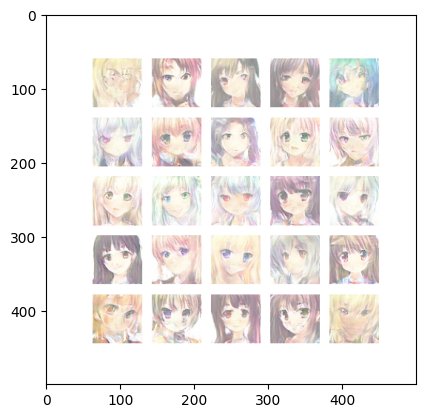

In [40]:
img = mpimg.imread('samples/generated_plot_epoch-60.png')
imgplot = plt.imshow(img)
plt.show()